<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/05-VectoresSem%C3%A1nticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Semántica Vectorial</h1>

En esta notebook usaremos dos módelos de semántica vectorial para diversas tareas de NLP. Los modelos que usaremos son:

* Bag of Words (BoW). [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* Term Frequency - Inverse Document Frequency (TF-IDF). [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Usando estos dos modelos realicermos tareas como:

* Vecinos más cercanos
* Information Retrieval
* Segmentación
* Clasificación


# 🟥 Ejercicios Tarea

En cada uno de los modelos BOW/TF-IDF que construyas puedes ajustar el hiperparámetro `max_features`.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import DBSCAN
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords, reuters
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('reuters')

[nltk_data] Downloading package stopwords to /home/jesusg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jesusg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to /home/jesusg/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

**Tarea de clasificación con el corpus `20newsgroups`**. Probar las siguientes estrategias y en cada caso medir el F1 score:

## 1. Todas las clases, sin quitar *headers*, *quotes*, *footers*. Comparar:
 * BOW
 * TF-IDF
 * BOW + PCA
 * TF-IDF + PCA
 * BOW + t-SNE
 * TF-IDF + t-SNE

In [3]:
train_docs_complete = fetch_20newsgroups(subset='train', remove=())
test_docs_complete = fetch_20newsgroups(subset='test', remove=())
y_train = train_docs_complete.target
y_test = test_docs_complete.target

In [4]:
df_dict = {
    'model': ['BoW','Tf-idf', 'BoW + PCA', 'Tf-idf + PCA', 'BoW + t-SNE', 'Tf-idf + t-SNE'],
    'f1_score': [],
}

### BoW

Antes de comenzar, podemos tratar de ver el comportamiento del `f1_score` en relación con el número de `max_features`, para tratar de seleccionar el mejor valor posible:

In [5]:
features = []
f1_scores = []

for feature in [None, 500, 1000, 1500, 2000, 2500]:
  print(f"Current max_features value: {feature}")
  cv = CountVectorizer(max_features=feature,stop_words='english')
  X_train = cv.fit_transform(train_docs_complete.data)
  X_test = cv.transform(test_docs_complete.data)

  lr = LogisticRegression(max_iter=500)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)

  if feature is None:
    features.append(0)
    f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
    continue

  features.append(feature)
  f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))

Current max_features value: None
Current max_features value: 500
Current max_features value: 1000
Current max_features value: 1500
Current max_features value: 2000
Current max_features value: 2500


/tmp/ipykernel_9497/190078531.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


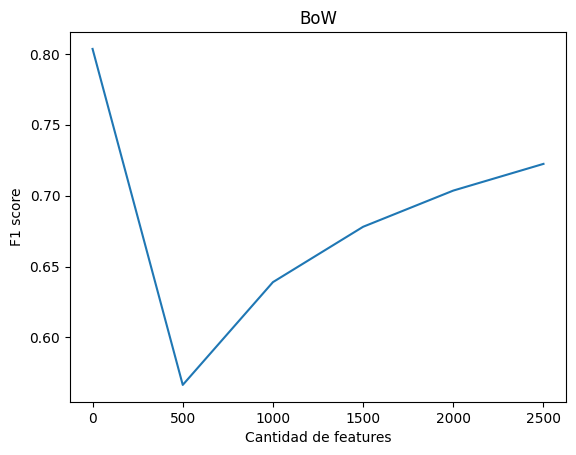

In [7]:
fig, ax = plt.subplots()
ax.plot(features, f1_scores)
ax.set_xlabel('Cantidad de features')
ax.set_ylabel('F1 score')
ax.set_title('BoW')
fig.show()

De la documentacion de `CountVectorizer`:

> **max_features**: *int*, default=`None`

>If not `None`, build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus. Otherwise, **all features are used**.

Vemos que al utilizar el valor de `None` en `max_features`, el vectorizador toma en cuenta todas las features del dataset (en este caso, un valor cercano a 130000). Con este valor obtenemos el mejor valor posible para el `f1_score`, pero podria ser mas costoso computacionalmente y ocasionar un consumo excesivo de recursos, por lo que utilizamos el valor de 2500.

In [8]:
cv = CountVectorizer(max_features=2500,stop_words='english')
X_train_bow = cv.fit_transform(train_docs_complete.data)
X_test_bow = cv.transform(test_docs_complete.data)

In [9]:
X_train_bow.shape, X_test_bow.shape

((11314, 2500), (7532, 2500))

In [10]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bow, y_train)
y_pred = lr.predict(X_test_bow)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.7224093364313849


In [11]:
df_dict['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Tf-idf

Podemos realizar un procedmiento similar al anterior para buscar el valor optimo de `max_features` para nuestro modelo:

In [13]:
features_tfidf = []
f1_scores_tfidf = []

for feature in [None, 500, 1000, 1500, 2000, 2500]:
  print(f'Current max_features value: {feature}')
  tf_idf = TfidfVectorizer(max_features=feature,stop_words='english')
  X_train = tf_idf.fit_transform(train_docs_complete.data)
  X_test = tf_idf.transform(test_docs_complete.data)

  lr = LogisticRegression(max_iter=500)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)

  if feature is None:
    features_tfidf.append(0)
    f1_scores_tfidf.append(f1_score(y_test, y_pred, average = 'weighted'))
    continue

  features_tfidf.append(feature)
  f1_scores_tfidf.append(f1_score(y_test, y_pred, average = 'weighted'))

Current max_features value: None
Current max_features value: 500
Current max_features value: 1000
Current max_features value: 1500
Current max_features value: 2000
Current max_features value: 2500


/tmp/ipykernel_9497/3717922263.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


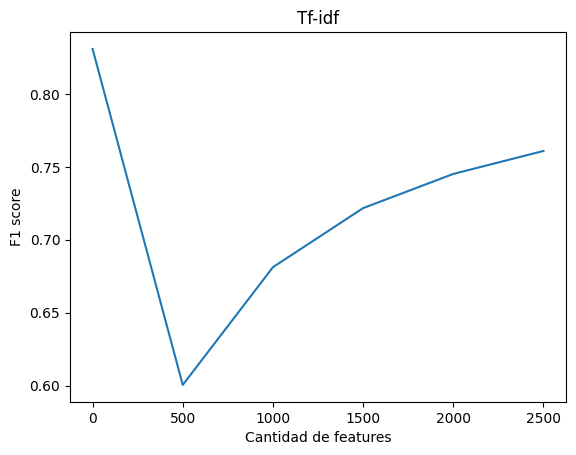

In [14]:
fig, ax = plt.subplots()
ax.plot(features_tfidf, f1_scores_tfidf)
ax.set_xlabel('Cantidad de features')
ax.set_ylabel('F1 score')
ax.set_title('Tf-idf')
fig.show()

De forma similar, vemos que el `f1_score` alcanza su valor maximo al utilizar todas las features. Sin embargo, como los recursos computacionales son limitados, usaremos un valor mas razonable, como 2500.

In [15]:
tf_idf = TfidfVectorizer(max_features=2500,stop_words='english')
X_train_tfidf = tf_idf.fit_transform(train_docs_complete.data)
X_test_tfidf = tf_idf.transform(test_docs_complete.data)

In [16]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.76085200049941


In [17]:
df_dict['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### BoW + PCA

Para el caso del PCA, podemos primero determinar la cantidad de componentes optima para nuestro analisis, utilizando la varianza explicada:

In [18]:
pca = PCA(n_components = 100)
pca.fit(X_train_bow.toarray())

PCA(n_components=100)

/tmp/ipykernel_9497/2571034636.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


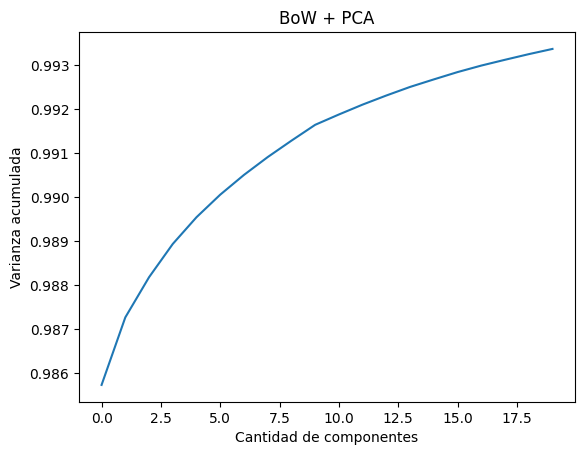

In [19]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(cumulative_variance[:20])
ax.set_xlabel('Cantidad de componentes')
ax.set_ylabel('Varianza acumulada')
ax.set_title('BoW + PCA')
fig.show()

Vemos que cualquier cantidad de componentes puede ser util para el PCA en este caso.

In [20]:
pca = PCA(n_components = 20)
X_train_bow_pca = pca.fit_transform(X_train_bow.toarray())
X_test_bow_pca = pca.transform(X_test_bow.toarray())

In [21]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bow_pca, y_train)
y_pred = lr.predict(X_test_bow_pca)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.38691366142540157


In [22]:
df_dict['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

En este caso, el valor del `f1_score` fue mucho menor a los anteriores, por lo que esta no parece ser una

### Tf-idf + PCA

In [23]:
pca = PCA()
pca.fit(X_train_tfidf.toarray())

PCA()

/tmp/ipykernel_9497/3172228070.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


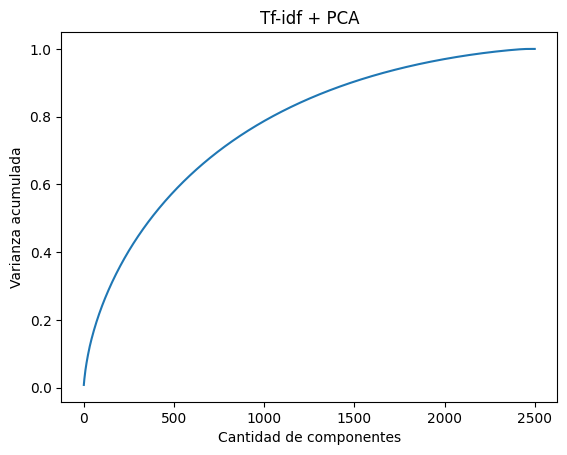

In [24]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(cumulative_variance)
ax.set_xlabel('Cantidad de componentes')
ax.set_ylabel('Varianza acumulada')
ax.set_title('Tf-idf + PCA')
fig.show()

In [25]:
next(x for x, val in enumerate(cumulative_variance) if val > 0.9)

1480

In [26]:
pca = PCA(n_components= 1480)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_tfidf_pca = pca.transform(X_test_tfidf.toarray())

In [27]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf_pca, y_train)
y_pred = lr.predict(X_test_tfidf_pca)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.7594335404188745


In [28]:
df_dict['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### BoW + t-SNE

In [29]:
tsne = TSNE(n_components=3, perplexity=30, metric = 'cosine')
X_train_bow_tsne = tsne.fit_transform(X_train_bow.toarray())
X_test_bow_tsne = tsne.fit_transform(X_test_bow.toarray())

In [30]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bow_tsne, y_train)
y_pred = lr.predict(X_test_bow_tsne)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.04742183182688986


In [31]:
df_dict['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Tf-idf + t-SNE

In [32]:
tsne = TSNE(n_components=3, perplexity=30, metric = 'cosine')
X_train_tfidf_tsne = tsne.fit_transform(X_train_tfidf.toarray())
X_test_tfidf_tsne = tsne.fit_transform(X_test_tfidf.toarray())

In [33]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf_tsne, y_train)
y_pred = lr.predict(X_test_tfidf_tsne)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.08610405157471018


In [34]:
df_dict['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Comparando las metricas obtenidas

Con las metricas que obtuvimos para cada caso, podemos generar un dataframe para compararlas con mayor facilidad:

In [35]:
df_complete = pd.DataFrame(df_dict)
df_complete

,model,f1_score
0,BoW,0.722409
1,Tf-idf,0.760852
2,BoW + PCA,0.386914
3,Tf-idf + PCA,0.759434
4,BoW + t-SNE,0.047422
5,Tf-idf + t-SNE,0.086104


Podemos generar un grafico de barras para poder comparar el desempeno de cada modelo mas facilemente:

/tmp/ipykernel_9497/2927392244.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


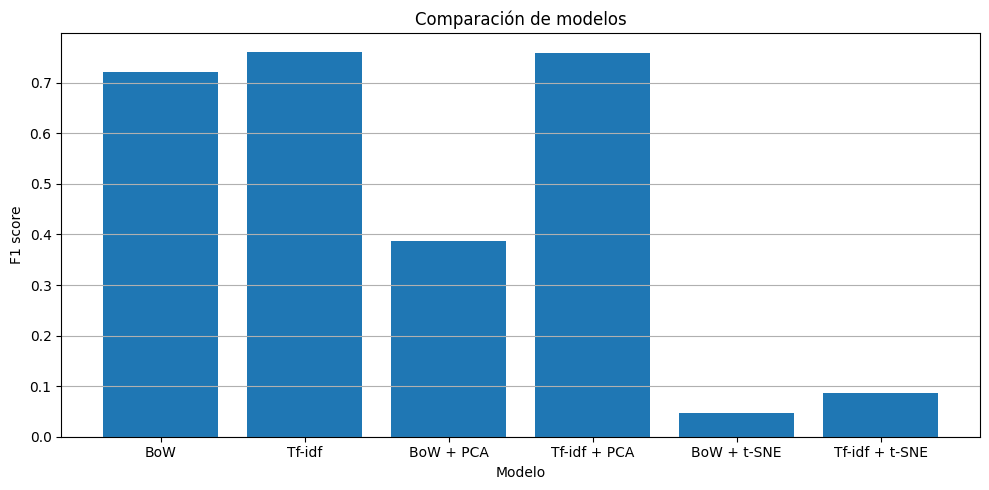

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.bar(df_complete['model'], df_complete['f1_score'])
ax.set_xlabel('Modelo')
ax.set_ylabel('F1 score')
ax.set_title('Comparación de modelos')
ax.grid(axis='y')
fig.tight_layout()
fig.show()

De lo anterior, podemos ver que el modelo que obtuvo un mayor puntaje F1 fue el de **Tf-idf** sin ninguna reduccion de dimensionalidad.

Los tres mejores modelos parecen haber sido:
1. Tf-idf
2. Tf-idf + PCA
3. BoW

## 2. Las mismas 6 estrategias del paso anterior, quitando *headers*, *quotes*, *footers*.

En este caso, el procedimiento es exactamente el mismo al de la seccion anterior, con la excepcion de que ahora el dataset no tendra los headers, footers ni quotes.

In [37]:
train_docs = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_docs = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [38]:
df_dict_noheaders = {
    'model': ['BoW','Tf-idf', 'BoW + PCA', 'Tf-idf + PCA', 'BoW + t-SNE', 'Tf-idf + t-SNE'],
    'f1_score': [],
}

El resto del procedimiento es exactamente el mismo:

### BoW

In [39]:
cv = CountVectorizer(max_features=2500,stop_words='english')
X_train_bow = cv.fit_transform(train_docs.data)
X_test_bow = cv.transform(test_docs.data)

In [40]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bow, y_train)
y_pred = lr.predict(X_test_bow)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.5509049947753528


In [41]:
df_dict_noheaders['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Tf-idf

In [42]:
tf_idf = TfidfVectorizer(max_features=2500,stop_words='english')
X_train_tfidf = tf_idf.fit_transform(train_docs.data)
X_test_tfidf = tf_idf.transform(test_docs.data)

In [43]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.6076051667344362


In [44]:
df_dict_noheaders['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### BoW + PCA

In [45]:
pca = PCA(n_components = 20)
X_train_bow_pca = pca.fit_transform(X_train_bow.toarray())
X_test_bow_pca = pca.transform(X_test_bow.toarray())

In [46]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bow_pca, y_train)
y_pred = lr.predict(X_test_bow_pca)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.30594012224646794


In [47]:
df_dict_noheaders['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Tf-idf + PCA

In [48]:
pca = PCA(n_components= 1480)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_tfidf_pca = pca.transform(X_test_tfidf.toarray())

In [49]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf_pca, y_train)
y_pred = lr.predict(X_test_tfidf_pca)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.6077281821302166


In [50]:
df_dict_noheaders['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### BoW + t-SNE

In [51]:
tsne = TSNE(n_components=3, perplexity=30, metric = 'cosine')
X_train_bow_tsne = tsne.fit_transform(X_train_bow.toarray())
X_test_bow_tsne = tsne.fit_transform(X_test_bow.toarray())

In [52]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bow_tsne, y_train)
y_pred = lr.predict(X_test_bow_tsne)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.047095895105401166


In [53]:
df_dict_noheaders['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Tf-idf + t-SNE

In [54]:
tsne = TSNE(n_components=3, perplexity=30, metric = 'cosine')
X_train_tfidf_tsne = tsne.fit_transform(X_train_tfidf.toarray())
X_test_tfidf_tsne = tsne.fit_transform(X_test_tfidf.toarray())

In [55]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf_tsne, y_train)
y_pred = lr.predict(X_test_tfidf_tsne)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.041656407856325635


In [56]:
df_dict_noheaders['f1_score'].append(f1_score(y_test, y_pred, average = 'weighted'))

### Comparando las metricas obtenidas

Finalmente, podemos comparar el desempeno de los modelos ahora que no se cuenta con headers, footers ni quotes dentro del dataset:

In [57]:
df_noheaders = pd.DataFrame(df_dict_noheaders)
df_noheaders

,model,f1_score
0,BoW,0.550905
1,Tf-idf,0.607605
2,BoW + PCA,0.305940
3,Tf-idf + PCA,0.607728
4,BoW + t-SNE,0.047096
5,Tf-idf + t-SNE,0.041656


/tmp/ipykernel_9497/3514382451.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


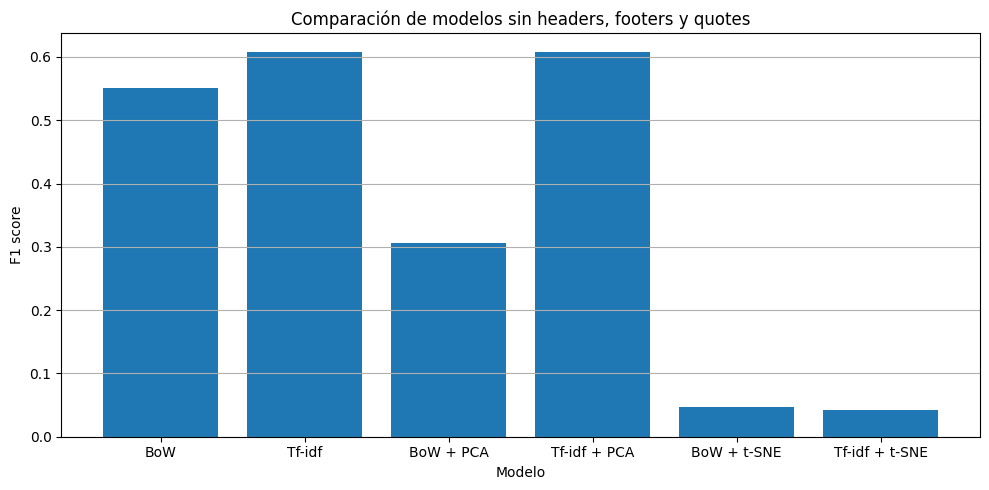

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.bar(df_noheaders['model'], df_noheaders['f1_score'])
ax.set_xlabel('Modelo')
ax.set_ylabel('F1 score')
ax.set_title('Comparación de modelos sin headers, footers y quotes')
ax.grid(axis='y')
fig.tight_layout()
fig.show()

En este caso vemos que los mismos tres modelos que se desempeñaron mejor en el caso anterior siguen siendo los tres mejores. Sin embargo, el desempeño de todos los modelos bajó en general, ya que en este caso apenas alcanzaron a obtener un score F1 por encima de 0.6.

## 3. Escoge dos clases que crees que se diferencien muy bien entre sí con estos modelos. ¿Qué clases escogiste y por qué? Compara BOW y TF-IDF para la clasificación binaria.

In [59]:
print(train_docs_complete.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


En mi caso, escogí las clases de `rec.sport.hockey` y `sci.space` porque me parecieron que no tienen muchos (o ningún) términos o temáticas en común, por lo que serían muy fáciles de diferenciar.

In [60]:
train_docs_binary = fetch_20newsgroups(subset='train', remove=(), categories=['rec.sport.hockey','sci.space'])
test_docs_binary = fetch_20newsgroups(subset='test', remove=(), categories=['rec.sport.hockey','sci.space'])

In [61]:
y_train_binary = train_docs_binary.target
y_test_binary = test_docs_binary.target

In [62]:
df_dict_binary = {
    'model': ['BoW','Tf-idf'],
    'f1_score': [],
}

### BoW para clasificacion binaria

In [63]:
cv = CountVectorizer(max_features=2500,stop_words='english')
X_train_bow = cv.fit_transform(train_docs_binary.data)
X_test_bow = cv.transform(test_docs_binary.data)

In [64]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bow, y_train_binary)
y_pred = lr.predict(X_test_bow)

print(f1_score(y_test_binary, y_pred, average = 'weighted'))

0.9899115030049832


In [65]:
df_dict_binary['f1_score'].append(f1_score(y_test_binary, y_pred, average = 'weighted'))

### Tf-idf para clasificacion binaria

In [66]:
tf_idf = TfidfVectorizer(max_features=2500,stop_words='english')
X_train_tfidf = tf_idf.fit_transform(train_docs_binary.data)
X_test_tfidf = tf_idf.transform(test_docs_binary.data)

In [67]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train_binary)
y_pred = lr.predict(X_test_tfidf)

print(f1_score(y_test_binary, y_pred, average = 'weighted'))

0.9936948698675241


In [68]:
df_dict_binary['f1_score'].append(f1_score(y_test_binary, y_pred, average = 'weighted'))

### Comparando los resultados

In [69]:
df_binary = pd.DataFrame(df_dict_binary)
df_binary

,model,f1_score
0,BoW,0.989912
1,Tf-idf,0.993695


En este caso donde las clases son muy diferentes entre sí, vemos que la diferencia en el score f1 para ambos métodos fue de menos de una centésima, por lo que ambos se desempeñan de muy buena manera.

## 4. Compara tu clasificador de la tarea pasada con el mejor clasificador del paso 3.

In [70]:
binary_train_dict = {
    'text': train_docs_binary.data,
    'Label': y_train_binary
}

binary_test_dict = {
    'text': test_docs_binary.data,
    'Label': y_test_binary
}

In [71]:
train_df_binary = pd.DataFrame(binary_train_dict)
test_df_binary = pd.DataFrame(binary_test_dict)

In [72]:
train_df_binary.head()

,text,Label
0,From: e8l6@jupiter.sun.csd.unb.ca (Rocket)\nSu...,0
1,From: umfu0009@ccu.umanitoba.ca (J. M. K. Fu)\...,0
2,From: Mark.Prado@p2.f349.n109.z1.permanet.org ...,1
3,From: igor@pravda.tse.su\nSubject: Who will br...,0
4,From: u1452@penelope.sdsc.edu (Jeff Bytof - SI...,1


In [76]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.util import ngrams
from string import punctuation
import spacy
import pandas as pd
import re
nltk.download('punkt_tab')
nlp = spacy.load('es_core_news_sm')

[nltk_data] Downloading package punkt_tab to /home/jesusg/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [77]:
class NgramsClassifier:
  """
  Clasificador basado en n-gramas para análisis de sentimiento.

  Atributos:
  -----------
  n : int
      El número de elementos en cada n-grama (por defecto es 2).
  dictionary : dict
      Diccionario que mapea n-gramas a un valor numérico, utilizado para la predicción.
  stemmer : SnowballStemmer
      Stemmer utilizado para realizar la derivación de palabras en español.
  """
  def __init__(self, n=2):
    """
    Inicializa el clasificador con el tamaño de n-grama especificado.

    Parámetros:
    -----------
    n : int
        El número de elementos en cada n-grama (por defecto es 2).
    """

    self.n = n
    self.dictionary = {}
    #self.stemmer = SnowballStemmer('spanish')

  def clean_string(self, text):
    """
    Limpia y preprocesa el texto eliminando puntuaciones, palabras vacías y dígitos.

    Parámetros:
    -----------
    text : str
        El texto que se desea limpiar.

    Retorna:
    --------
    str
        Texto limpio y preprocesado.
    """
    stop_words = set(stopwords.words('english'))
    punctuations = set(punctuation)
    punctuations.add('...')
    punctuations.add("''")
    punctuations.add('``')
    punctuations.add('“')
    punctuations.add('¡')
    punctuations.add('¿')

    text.replace('"','')
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    for p in punctuations:
      text = text.replace(p, '')
    for s in stop_words:
      if s == 'no':
        continue
      text = re.sub(r'\b%s\b' %s, '', text)

    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'\n', '', text)

    return text

  def lemmatize(self, text):
    """
    Realiza la lematización del texto, convirtiendo las palabras a su forma base.

    Parámetros:
    -----------
    text : str
        El texto que se desea lematizar.

    Retorna:
    --------
    str
        Texto lematizado.
    """
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

  def stem(self, text):
    """
    Realiza la derivación (stemming) del texto, reduciendo las palabras a su raíz.

    Parámetros:
    -----------
    text : str
        El texto que se desea derivar.

    Retorna:
    --------
    str
        Texto derivado.
    """
    return ' '.join([self.stemmer.stem(word) for word in text.split()])


  def fit(self, X, y) -> None:
    """
    Entrena el clasificador utilizando una lista de textos y sus correspondientes etiquetas.

    Parámetros:
    -----------
    X : list str
        Lista de textos para el entrenamiento.
    y : list int
        Lista de etiquetas correspondientes a cada texto en X, donde 1 indica sentimiento positivo y 0 indica negativo.

    Retorna:
    --------
    None
    """
    df = pd.DataFrame(list(zip(X, y)), columns=['text', 'Label'])
    for index, row in df.iterrows():
      key = self.clean_string(str(row['text']))
      key = self.lemmatize(key)
      # key = self.stem(key)
      key = word_tokenize(key, language='spanish')
      key_ngrams = ngrams(key, self.n)
      for ngram in key_ngrams:
        if ngram not in self.dictionary:
          self.dictionary[ngram] = 0
        if row['Label'] == 1:
          self.dictionary[ngram] += 1
        else:
          self.dictionary[ngram] -= 1

  def predict(self, X):
    """
    Predice las etiquetas de una lista de textos utilizando el modelo entrenado.

    Parámetros:
    -----------
    X : list str
        Lista de textos para los que se desea predecir las etiquetas.

    Retorna:
    --------
    list int
        Lista de etiquetas predichas, donde 1 indica sentimiento positivo y 0 indica negativo.
    """
    df = pd.DataFrame(X, columns=['text'])
    predictions = []
    for index, row in df.iterrows():
      counter = 0
      key = self.clean_string(str(row['text']))
      key = self.lemmatize(key)
      key = word_tokenize(key, language='spanish')
      key_ngrams = ngrams(key, self.n)
      for key in key_ngrams:
        if key not in self.dictionary:
          continue
        if self.dictionary[key] > 0:
          counter += 1
        elif self.dictionary[key] < 0:
          counter -= 1

      if counter >= 0:
        predictions.append(1)
      else:
        predictions.append(0)

    return predictions

In [78]:
model = NgramsClassifier()
model.fit(train_docs_binary.data, train_docs_binary.target)
y_pred = model.predict(test_docs_binary.data)

print(f1_score(y_test_binary, y_pred, average = 'weighted'))

0.9861287578238601


## 5. Escoge ahora dos clases que crees que no se diferencien entre sí con estos modelos. ¿Qué clases escogiste y por qué? Compara BOW y TF-IDF para la clasificación binaria. ¿Qué tanto bajó el rendimiento respecto al paso 3?

In [79]:
train_docs_binary_similar = fetch_20newsgroups(subset='train', remove=(), categories=['comp.os.ms-windows.misc','comp.windows.x'])
test_docs_binary_similar = fetch_20newsgroups(subset='test', remove=(), categories=['comp.os.ms-windows.misc','comp.windows.x'])

In [80]:
y_train_binary_similar = train_docs_binary_similar.target
y_test_binary_similar = test_docs_binary_similar.target

In [81]:
df_dict_binary_similar = {
    'model': ['BoW','Tf-idf'],
    'f1_score': [],
}

### BoW

In [82]:
cv = CountVectorizer(max_features=2500,stop_words='english')
X_train_bow = cv.fit_transform(train_docs_binary_similar.data)
X_test_bow = cv.transform(test_docs_binary_similar.data)

In [83]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bow, y_train_binary_similar)
y_pred = lr.predict(X_test_bow)

print(f1_score(y_test_binary_similar, y_pred, average = 'weighted'))

0.8782190149084114


In [84]:
df_dict_binary_similar['f1_score'].append(f1_score(y_test_binary_similar, y_pred, average = 'weighted'))

### Tf-idf

In [85]:
tf_idf = TfidfVectorizer(max_features=2500,stop_words='english')
X_train_tfidf = tf_idf.fit_transform(train_docs_binary_similar.data)
X_test_tfidf = tf_idf.transform(test_docs_binary_similar.data)

In [86]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train_binary_similar)
y_pred = lr.predict(X_test_tfidf)

print(f1_score(y_test_binary_similar, y_pred, average = 'weighted'))

0.9175377610780505


In [87]:
df_dict_binary_similar['f1_score'].append(f1_score(y_test_binary_similar, y_pred, average = 'weighted'))

### Comparando resultados

In [88]:
df_binary_similar = pd.DataFrame(df_dict_binary_similar)
df_binary_similar

,model,f1_score
0,BoW,0.878219
1,Tf-idf,0.917538


Comparando con las métricas obtenidas en el caso anterior, donde las clases eran mas "diferenciables":

In [89]:
df_binary

,model,f1_score
0,BoW,0.989912
1,Tf-idf,0.993695


En este caso, podemos ver que cuando las clases son muy similares, tenemos una disminución considerable (más del 10%) en el rendimento de nuestro clasificadores, tanto para el modelo BoW como el tf-idf.

## 6. En tu mejor clasificador del paso 3, prueba bajando y subiendo el parámetro `max_features` ¿qué efecto tiene esto en la tarea de clasificación?

In [90]:
features_binary = []
f1_scores_binary = []

for feature in range(1000, 3000, 100):
  tf_idf = TfidfVectorizer(max_features=feature)
  X_train_tfidf = tf_idf.fit_transform(train_docs_binary.data)
  X_test_tfidf = tf_idf.transform(test_docs_binary.data)

  lr = LogisticRegression(max_iter=500)
  lr.fit(X_train_tfidf, y_train_binary)
  y_pred = lr.predict(X_test_tfidf)

  features_binary.append(feature)
  f1_scores_binary.append(f1_score(y_test_binary, y_pred, average = 'weighted'))
  print(f"max_features: {feature}, f1 score: {(f1_score(y_test_binary, y_pred, average = 'weighted'))}")

max_features: 1000, f1 score: 0.9911728178145338
max_features: 1100, f1 score: 0.9911728178145338
max_features: 1200, f1 score: 0.9911728178145338
max_features: 1300, f1 score: 0.9924337957124842
max_features: 1400, f1 score: 0.9924337957124842
max_features: 1500, f1 score: 0.9924337957124842
max_features: 1600, f1 score: 0.9911728178145338
max_features: 1700, f1 score: 0.9911728178145338
max_features: 1800, f1 score: 0.9911728178145338
max_features: 1900, f1 score: 0.9924338679044977
max_features: 2000, f1 score: 0.9924338679044977
max_features: 2100, f1 score: 0.9924338679044977
max_features: 2200, f1 score: 0.9924338679044977
max_features: 2300, f1 score: 0.9924338679044977
max_features: 2400, f1 score: 0.9924338679044977
max_features: 2500, f1 score: 0.9924338679044977
max_features: 2600, f1 score: 0.9924338679044977
max_features: 2700, f1 score: 0.9924338679044977
max_features: 2800, f1 score: 0.9924338679044977
max_features: 2900, f1 score: 0.9924338679044977


/tmp/ipykernel_9497/23494127.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


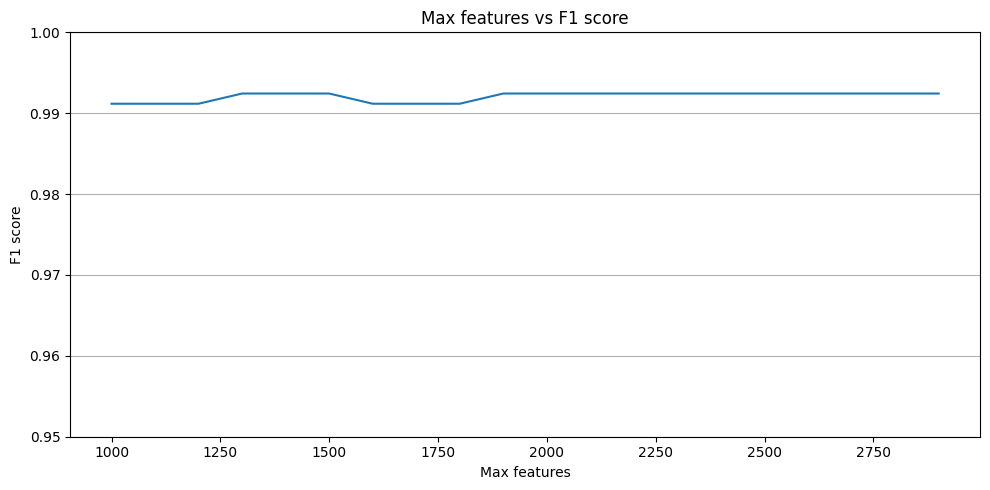

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(features_binary, f1_scores_binary)
ax.set_xlabel('Max features')
ax.set_ylabel('F1 score')
ax.set_title('Max features vs F1 score')
ax.grid(axis='y')
ax.set_ylim(0.95, 1)
fig.tight_layout()
fig.show()

Como podemos ver en la gráfica, si variamos el valor del parámetro `max_features`, no hay una variación considerable del valor del `f1 score`, ya que la variación está en la escala de las *milésimas*.

## 7. **Crédito extra**: ¿Qué efecto tiene lematizar el texto en la tarea de clasificación? Prueba con tu mejor clasificador binario.

In [92]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jesusg/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/jesusg/nltk_data...


True

In [93]:
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Lowercase and remove non-alphabetic tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(lemmatized_tokens)

In [94]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [95]:
X_train_lemma = [preprocess_text(text) for text in train_docs_complete.data]
X_test_lemma = [preprocess_text(text) for text in test_docs_complete.data]

In [96]:
print(X_train_lemma[0])

lerxst thing subject car organization university maryland college park line wondering anyone could enlighten car saw day sport car looked late early called bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car made history whatever info funky looking car please thanks il brought neighborhood lerxst


In [97]:
print(train_docs_complete.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [98]:
tf_idf = TfidfVectorizer(max_features=2500)
X_train_tfidf = tf_idf.fit_transform(X_train_lemma)
X_test_tfidf = tf_idf.transform(X_test_lemma)

In [99]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print(f1_score(y_test, y_pred, average = 'weighted'))

0.7609309069722558


Aqui podemos ver que la lematización del texto, en este caso, afecta de manera negativa nuestro clasificador, y reduce considerablemente la precisión del mismo.

## **Information Retrieval con el corpus `20newsgroups`** Entrena un modelo BOW y un TF-IDF con todos los documentos juntos de `train` y `test`. Realiza algunas consultas al modelo para obtener los documentos más relevantes para tu busqueda. Reporta algunos casos que creas interesantes y explica porque los consideras interesantes.

In [100]:
docs_all = fetch_20newsgroups(subset='all', remove=())

### Tf-idf

In [101]:
tf_idf = TfidfVectorizer(max_features=2500)
X_all_tfidf = tf_idf.fit_transform(docs_all.data)

In [102]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(X_all_tfidf)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [103]:
query = "computers and ai development"

query_vector = tf_idf.transform([query]).toarray().reshape(-1,)

responses = nn.kneighbors([query_vector])
for idx, dist in zip(responses[1][0],responses[0][0]):
    print(f"Distancia: {round(dist,3)}")
    print(f"{docs_all.data[idx]}\n")

Distancia: 0.636
From: oaf@zurich.ai.mit.edu (Oded Feingold)
Subject: where is
Organization: M.I.T. Artificial Intelligence Lab.
Lines: 5
Reply-To: oaf@zurich.ai.mit.edu
NNTP-Posting-Host: klosters.ai.mit.edu


... Wayne McGuire?  Did someone prove he's anon15031@anon.penet.fi,
and he ran off to restock on PCP?

Miss him.  (sniff)


Distancia: 0.646
From: xyzzy@hal.gnu.ai.mit.edu (Daniel Drucker)
Subject: Re: Where did the hacker ethic go?
Organization: dis
Lines: 18
NNTP-Posting-Host: hal.ai.mit.edu

In article <gradyC6D7Ep.AwE@netcom.com> grady@netcom.com (1016/2EF221) writes:
>Where did the hacker ethic go?
>
>We hackers of the 70's and 80' are now comfortably employed
>and supporting families.  The next generation takes
>the radical lead now.  Don't look for radicalism among us
>old ones; we're gone...

And guess who's here in your place.

Please finger xyzzy@gnu.ai.mit.edu for information, or if you are
a mail/news only site, mail xyzzy@gnu.ai.mit.edu with the subject line
"SEND F

### BoW

In [104]:
cv = CountVectorizer(max_features=2500)
X_all_bow = cv.fit_transform(docs_all.data)

In [105]:
nn_bow = NearestNeighbors(n_neighbors=10, metric='cosine')
nn_bow.fit(X_all_bow)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [106]:
query = "computers and ai development"

query_vector = cv.transform([query]).toarray().reshape(-1,)

responses = nn_bow.kneighbors([query_vector])
for idx, dist in zip(responses[1][0],responses[0][0]):
    print(f"Distancia: {round(dist,3)}")
    print(f"{docs_all.data[idx]}\n")

Distancia: 0.648
From: walter@uni-koblenz.de (Walter Hower)
Subject: Re: PARAMETRIC/VARIATIONAL DESIGN
Organization: University of Koblenz, Germany
Lines: 149
NNTP-Posting-Host: wolf.uni-koblenz.de
In-reply-to: patel@enuxha.eas.asu.edu's message of Wed, 28 Apr 1993 18:15:40 GMT

Here now some initial references; best regards - Walter.
@InProceedings{Keirouz:et:al:90,
  author = 	"Walid Keirouz and Jahir Pabon and Robert Young",
  title = 	"{Integrating parametric geometry, features, and
		 variational modeling for conceptual design}",
  booktitle = 	"International Conference on Design Theory and Methodology",
  year = 	"1990",
  editor = 	"{J.\ R.}\ Rinderle",
  pages = 	"1--9",
  organization = 	"American Society of Mechanical Engineers (ASME)",
  OPTpublisher = 	"",
  OPTaddress = 	"",
  OPTmonth = 	"",
  note = 	"Proceedings"
}


@InProceedings{Yamaguchi:Kimura:90,
  author = 	"Yasushi Yamaguchi and Fumihiko Kimura",
  title = 	"{A constraint modeling system for variational geometry

## **Análisis de sentimientos con BOW/TFIDF**. Usando el corpus de la tarea anterior (el de turismo), entrena un clasificador de Machine Learning con los embeddings BOW/TF-IDF, ¿mejora el rendimiento respecto al que presentaste en clase?

In [115]:
from sklearn.model_selection import train_test_split

In [111]:
resenas_df = pd.read_csv('../../datasets/pln/resenas/train.csv',index_col=0)
resenas_df.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""No es para recomendarse""","""Las famosas momias de Guanajuato. El museo en...",Museo de las Momias,Male,48,México,02/07/2013,0
1,"""Es un mercado tradicional, no es nada del otr...","""Allí puedes encontrar comida o souvenirs. Es ...",Mercado Hidalgo,Male,52,México,06/09/2016,0
2,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",Museo de las Momias,Male,42,México,25/12/2017,0
3,"""No le veo atractivo. A ver semejantes cacharros""","""Entiendo que a muchos les cautive o llamé la ...",Museo de las Momias,Female,24,México,14/08/2013,0
4,"""Nada fuera de lo común""","""La fruta y verdura son poco frescos, al igual...",Mercado Hidalgo,Female,19,México,01/08/2017,0


In [112]:
resenas_df = resenas_df.drop(columns=['Place','Gender','Age','Country','Date'])
resenas_df['text'] = resenas_df['Title'] + resenas_df['Opinion']
resenas_df = resenas_df.drop(columns=['Title','Opinion'])
resenas_df.head()

,Label,text
0,0,"""No es para recomendarse""""Las famosas momias d..."
1,0,"""Es un mercado tradicional, no es nada del otr..."
2,0,"""No visitar""""Es tardado entrar al museo, una v..."
3,0,"""No le veo atractivo. A ver semejantes cacharr..."
4,0,"""Nada fuera de lo común""""La fruta y verdura so..."


In [131]:
resenas_df = resenas_df.fillna('')

In [132]:
X = resenas_df['text']
y = resenas_df['Label']

In [116]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [133]:
X_test = pd.read_csv('../../datasets/pln/resenas/test_features.csv',index_col = 0)
X_test.head()

,Title,Opinion,Place,Gender,Age,Country,Date
0,"""No coman ahí""","""Creo que es muy insalubre, hay basura por tod...",Mercado Hidalgo,Female,61,México,15/01/2013
1,"""Romántico""","""Es un callejón común donde todos toman fotos ...",Callejón del Beso,Female,42,Uruguay,22/06/2015
2,Muy descuidado,"Cierto, es un mercado, pero no por eso hay que...",Mercado Hidalgo,Male,-1,México,2019
3,"""Impresionante""","""El acabado del altar es sumamente bonito, aun...",Basilica Colegiata,Male,26,México,08/10/2013
4,"""No es lo máximo""","""De todo lo hermoso que tiene Guanajuato esto ...",Basilica Colegiata,Female,54,México,10/01/2012


In [134]:
X_test = X_test.drop(columns=['Place','Gender','Age','Country','Date'])
X_test['text'] = X_test['Title'] + X_test['Opinion']
X_test = X_test.drop(columns=['Title','Opinion'])
X_test.head()

,text
0,"""No coman ahí""""Creo que es muy insalubre, hay ..."
1,"""Romántico""""Es un callejón común donde todos t..."
2,"Muy descuidadoCierto, es un mercado, pero no p..."
3,"""Impresionante""""El acabado del altar es sumame..."
4,"""No es lo máximo""""De todo lo hermoso que tiene..."


In [139]:
y_test = np.load('../../datasets/pln/resenas/test_labels.npy')

### BoW

In [144]:
cv = CountVectorizer(max_features=2500, stop_words=stopwords.words('spanish'))
X_bow = cv.fit_transform(X)
X_test_bow = cv.transform(X_test['text'].values)

lr = LogisticRegression()
lr.fit(X_bow,y)

LogisticRegression()

In [149]:
y_pred = lr.predict(X_test_bow)
print(f1_score(y_test, y_pred))

0.9145880574452003


### Tf-idf

In [150]:
tf_idf = TfidfVectorizer(max_features=2500, stop_words=stopwords.words('spanish'))
X_tfidf = tf_idf.fit_transform(X)
X_test_tfidf = tf_idf.transform(X_test['text'].values)

lr = LogisticRegression()
lr.fit(X_tfidf, y)

LogisticRegression()

In [151]:
y_pred = lr.predict(X_test_tfidf)
print(f1_score(y_test, y_pred))

0.9214131218457101


Con el modelo presentado en la clase, obtuvimos un `f1 score` de aproximadamente 0.89. Comparandolo con lás métricas obtenidas aquí, podemos apreciar una mejora en la clasificación de las reseñas, aunque puede que no sea tan considerable, ya que el modelo presentado en clase habia demostrado una buena capacidad de clasificación por sí mismo.